In [1]:
from dl import authClient as ac, queryClient as qc, storeClient as sc, helpers
import pylab as plt
import numpy as np
from astropy.io import fits
import matplotlib as mpl
import math
import astropy.io.fits as fits
from astropy.table import Table, Column
import scipy.optimize as sp

In [2]:
token=ac.login('mgkadrmas')

In [3]:
df=Table(fits.getdata('LMCParallax4.fits'))
df['Dist']=1/df['parallax']
df['Disterror']=df['sigma']/(df['parallax']**2)

In [4]:
def onclick(event):
    print('%s click: button=%d, x=%d, y=%d, xdata=%f, ydata=%f' %
          ('double' if event.dblclick else 'single', event.button,
           event.x, event.y, event.xdata, event.ydata))
    
    
    
def roi_cut(xcut,ycut,x,y): 
    from matplotlib.path import Path
    tupVerts = list(zip(xcut,ycut))
    points = np.vstack((x,y)).T
    p = Path(tupVerts) # make a polygon
    inside = p.contains_points(points)
    ind, = np.where(~inside)
    cutind, = np.where(inside)
    return ind, cutind
    print (ind, cutind)

In [5]:
xcut=[102.237903,99.022177,95.584677,90.372984,85.715726,75.625000,71.189516,67.752016,63.981855,62.207661,59.879032,58.770161,57.217742,56.219758,59.213710,63.870968,71.522177,78.840726,87.046371,93.256048,100.020161,103.014113,104.012097]
ycut=[-64.938814,-63.151940,-61.439520,-59.801552,-58.312490,-58.238037,-58.461396,-59.429286,-60.173817,-62.109597,-65.385533,-68.512562,-71.490685,-75.138886,-76.851306,-77.893650,-78.489274,-78.191462,-78.191462,-77.521384,-75.362245,-72.458575,-68.438109]
x=df['ra'].ravel()
y=df['dec'].ravel()
(ind, cutind) = roi_cut(xcut,ycut,x,y)


In [6]:
def InclineDiskDist(ra, dec, pa, io, d0):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(81.9) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(-69.866667) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dist = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dist


In [7]:
def creatediskmodel(theta, inclin, Distcenter):
    dtype=np.dtype([('ra',float),('dec',float),('distheory',float)])
    cat = np.zeros([56,26], dtype=dtype)
    for x in range (56):
        ra=x+55
        for y in range (26):
            dec=y-80
            (distheory) = InclineDiskDist(ra,dec,theta,inclin,Distcenter)
            cat[x,y]['ra']=ra
            cat[x,y]['dec']=dec
            cat[x,y]['distheory']=distheory
    return cat

In [8]:
x0=np.array([235,25,50],dtype=float)

def findbestdiskmodel(cat):
    def residuals(x):
        model=creatediskmodel(x[0], x[1], x[2])
        return (cat['Dist'].ravel()[cutind] - model['distheory'].ravel()[cutind])
    soln=sp.least_squares(residuals, x0, bounds=([0, 0, 0], [360, 60, np.inf]))
    theta = soln.x[0]
    inclin = soln.x[1]
    Distcenter = soln.x[2]
    return theta, inclin, Distcenter

In [9]:
findbestdiskmodel(df)

(235.3451184146557, 52.73165553741655, 48.92351491747575)

In [ ]:
dtype=np.dtype([('theta',float),('inclin',float),('distcenter',float)])
MC = np.zeros(100, dtype=dtype)

model = creatediskmodel(235.276, 52.75566, 48.92247)

for t in range(100):
    synth = df.copy()
    synth['Dist'] = model['distheory'] + np.random.randn(model.shape[0],model.shape[1])*df['Disterror']
    synth['Disterror'] = df['Disterror']
    theta, inclin, distcenter = findbestdiskmodel(synth)
    MC[t]['theta'] = theta
    MC[t]['inclin'] = inclin
    MC[t]['distcenter'] = distcenter

MC = Table(MC)
MC.write('LMCPlxMCbig5.fits', format='fits')

In [11]:
MC=fits.getdata('LMCPlxMCbig5.fits')

In [13]:
np.std(MC['theta'])

151.16512825705118

In [14]:
np.std(MC['inclin'])

24.379313275680232

In [15]:
np.std(MC['distcenter'])

110.87883470704675

(array([20.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 79.]),
 array([1.43682316e-10, 1.20000000e+00, 2.40000000e+00, 3.60000000e+00,
        4.80000000e+00, 6.00000000e+00, 7.20000000e+00, 8.40000000e+00,
        9.60000000e+00, 1.08000000e+01, 1.20000000e+01, 1.32000000e+01,
        1.44000000e+01, 1.56000000e+01, 1.68000000e+01, 1.80000000e+01,
        1.92000000e+01, 2.04000000e+01, 2.16000000e+01, 2.28000000e+01,
        2.40000000e+01, 2.52000000e+01, 2.64000000e+01, 2.76000000e+01,
        2.88000000e+01, 3.00000000e+01, 3.12000000e+01, 3.24000000e+01,
        3.36000000e+01, 3.48000000e+01, 3.60000000e+01, 3.72000000e+01,
        3.84000000e+01, 3.96000000e+01, 4.08000000e+01, 4.20000000e+01,
        4.32000000e+01, 4.44000000e+01, 4.56000000e+01, 4.68000000e+

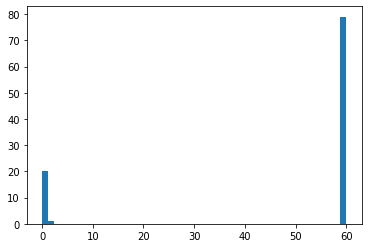

In [16]:
plt.hist(MC['inclin'], bins=50)

(array([28.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  2.,  0.,  1.,
         0.,  0.,  1.,  2.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  3., 18., 21.,  3., 12.]),
 array([5.14619343e-18, 7.20000000e+00, 1.44000000e+01, 2.16000000e+01,
        2.88000000e+01, 3.60000000e+01, 4.32000000e+01, 5.04000000e+01,
        5.76000000e+01, 6.48000000e+01, 7.20000000e+01, 7.92000000e+01,
        8.64000000e+01, 9.36000000e+01, 1.00800000e+02, 1.08000000e+02,
        1.15200000e+02, 1.22400000e+02, 1.29600000e+02, 1.36800000e+02,
        1.44000000e+02, 1.51200000e+02, 1.58400000e+02, 1.65600000e+02,
        1.72800000e+02, 1.80000000e+02, 1.87200000e+02, 1.94400000e+02,
        2.01600000e+02, 2.08800000e+02, 2.16000000e+02, 2.23200000e+02,
        2.30400000e+02, 2.37600000e+02, 2.44800000e+02, 2.52000000e+02,
        2.59200000e+02, 2.66400000e+02, 2.73600000e+02, 2.80800000e+

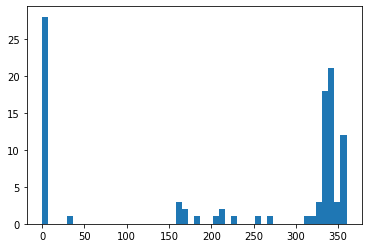

In [17]:
plt.hist(MC['theta'], bins=50)

(array([28.,  2.,  1.,  3.,  2.,  4.,  2.,  2.,  3.,  2.,  2.,  2.,  1.,
         1.,  3.,  0.,  5.,  2.,  0.,  4.,  3.,  2.,  1.,  0.,  0.,  2.,
         1.,  4.,  3.,  1.,  3.,  0.,  0.,  1.,  2.,  0.,  2.,  0.,  0.,
         1.,  1.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  1.]),
 array([1.85917173e-11, 8.21806609e+00, 1.64361322e+01, 2.46541983e+01,
        3.28722643e+01, 4.10903304e+01, 4.93083965e+01, 5.75264626e+01,
        6.57445287e+01, 7.39625948e+01, 8.21806609e+01, 9.03987269e+01,
        9.86167930e+01, 1.06834859e+02, 1.15052925e+02, 1.23270991e+02,
        1.31489057e+02, 1.39707123e+02, 1.47925190e+02, 1.56143256e+02,
        1.64361322e+02, 1.72579388e+02, 1.80797454e+02, 1.89015520e+02,
        1.97233586e+02, 2.05451652e+02, 2.13669718e+02, 2.21887784e+02,
        2.30105850e+02, 2.38323916e+02, 2.46541983e+02, 2.54760049e+02,
        2.62978115e+02, 2.71196181e+02, 2.79414247e+02, 2.87632313e+02,
        2.95850379e+02, 3.04068445e+02, 3.12286511e+02, 3.20504577e+

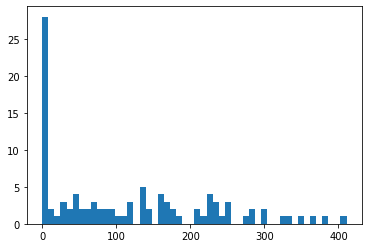

In [18]:
plt.hist(MC['distcenter'], bins=50)